In [1]:
import pandas as pd
from datetime import datetime
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import time
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import cPickle
CSV_PATH='/home/kvassay/data/book-recommender/ratings_Books.csv'
QUESTIONS_PATH='/home/kvassay/data/book-recommender/questions.txt'
MODELS_FOLDER='/home/kvassay/data/book-recommender/models/'
BEST_CFG_PATH='/home/kvassay/data/book-recommender/best_cfg.dump'
%matplotlib inline

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.') #to prevent duplicate logs

2016-12-14 11:40:16,698 - root - INFO - Logger works.


### Reading and sorting data

In [3]:
raw_data=pd.read_csv(CSV_PATH,header=0,names=['user','item','rating','timestamp'])

### Dumping data < 2013.

In [4]:
raw_data=raw_data[raw_data['timestamp']>1356998400]

### Extract user-item impressions dict

In [5]:
def split(raw_data, quantile=0.7):
    q=raw_data['timestamp'].quantile(quantile)
    return raw_data[raw_data['timestamp']<=q], raw_data[raw_data['timestamp']>q]

def get_user_items_dict(data, min_ratings, max_ratings):
    user_item_dict=dict()
    for row in data.itertuples():
        if row.user in user_item_dict:
            user_item_dict[row.user].append(row.item)
        else:
            user_item_dict[row.user]=[row.item]
    user_item_dict_clean={key: value for key,value in user_item_dict.iteritems() if len(value)>=min_ratings and len(value)<max_ratings}
    return user_item_dict_clean

def get_user_items_list_lengths(user_item_dict):
    return pd.DataFrame(sorted([len(item_list) for _,item_list in user_item_dict.iteritems()]))
    

def remove_users_not_in_train(train_dict, other_dict):
    #intersection=set(other_dict.keys()) & set(train_dict.keys())
    #n_intersection=len(intersection)
    #new_dict={key: other_dict[key] for key in intersection}
    #len_before=len(other_dict)
    #n_removed = len_before - len(new_dict)
    #logger.info('Removed %s users which weren\'t in the training set. Intersection cardinality: %s...', n_removed, n_intersection)
    keys=other_dict.keys()
    for key in keys:
        if not key in train_dict:
            del other_dict[key]
    return other_dict

### Train-test split

In [6]:
raw_train, raw_test = split(raw_data)
raw_train, raw_dev = split(raw_train)

In [7]:
user_item_train = get_user_items_dict(raw_train, min_ratings=10, max_ratings=100)
user_item_dev = get_user_items_dict(raw_dev, min_ratings=1, max_ratings=100)
user_item_test = get_user_items_dict(raw_test, min_ratings=1, max_ratings=100)

user_item_dev=remove_users_not_in_train(user_item_train, user_item_dev)
user_item_test= remove_users_not_in_train(user_item_train, user_item_test)

### Training dataset Analysis

#### User count

In [8]:
len(user_item_train.keys())

62105

#### Item count distribution per user

In [9]:
item_counts_train=get_user_items_list_lengths(user_item_train)
item_counts_dev=get_user_items_list_lengths(user_item_dev)
item_counts_test=get_user_items_list_lengths(user_item_test)

In [10]:
item_counts_train.describe()

,0
count,62105.000000
mean,20.078190
std,14.454616
min,10.000000
25%,11.000000
50%,15.000000
75%,22.000000
max,99.000000


In [11]:
item_counts_dev.describe()

,0
count,43248.000000
mean,7.958356
std,9.931169
min,1.000000
25%,2.000000
50%,5.000000
75%,10.000000
max,99.000000


In [12]:
item_counts_test.describe()

,0
count,42702.000000
mean,9.157112
std,11.883411
min,1.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bd6bf8050>]], dtype=object)

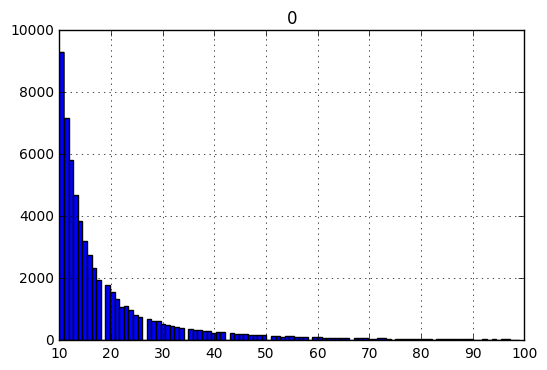

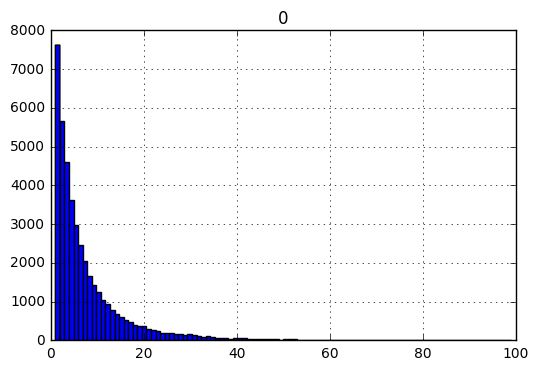

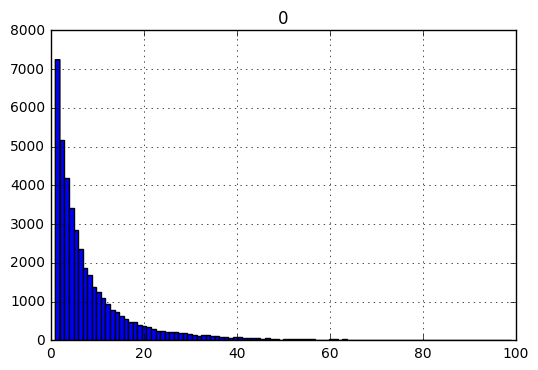

In [13]:
nbins=100
item_counts_train.hist(bins=nbins)
item_counts_dev.hist(bins=nbins)
item_counts_test.hist(bins=nbins)

### Limiting dataset sizes

Especially evaluations take a lot of time, limiting dataset sizes might be useful.

In [14]:
#for testing:
TRAIN_SIZE=100000
DEV_SIZE=1000
TEST_SIZE=1000
'''
In addition to limiting the dataset sizes we need to make sure, 
that all users from DEV and TEST set are present in TRAIN set.
To do that we simply add them to TRAIN set after limiting.
'''
user_item_train_tmp={key: user_item_train[key] for key in user_item_train.keys()[:TRAIN_SIZE]}
user_item_dev={key: user_item_dev[key] for key in user_item_dev.keys()[:DEV_SIZE]}
user_item_test={key: user_item_test[key] for key in user_item_test.keys()[:TEST_SIZE]}
for usr in user_item_dev:
    if usr not in user_item_train_tmp:
        user_item_train_tmp[usr]=user_item_train[usr]
for usr in user_item_test:
    if usr not in user_item_train_tmp:
        user_item_train_tmp[usr]=user_item_train[usr]
user_item_train=user_item_train_tmp

In [15]:
print([len(user_item_train), len(user_item_dev), len(user_item_test)])

[62105, 1000, 1000]


### Training data preparation
For Gensim

In [16]:
train_data=[TaggedDocument([unicode(word) for word in words], [user_id]) for user_id, words in user_item_train.iteritems()]
dev_data=[TaggedDocument([unicode(word) for word in words], [user_id]) for user_id, words in user_item_dev.iteritems()]


### Baseline model and evaluation function
Evaluation methods and Baseline model for comparison.

In [39]:
class BaselineModel():
    '''
    Always returns k most frequent items.
    '''
    def __init__(self,train_set,topn=100):
        logger.info('Couting %s most frequent items for BaselineModel...',topn)
        items=list()
        for key in train_set:
            items.extend(train_set[key])
        counter=Counter(items)
        self.result=counter.most_common(topn)
        logger.info('BaselineModel initialized...')
        
    def most_similar(self, positive=None, topn=None):
        #parameters are there just for compatibility with Gensim model evaluator
        return self.result
        
        
def percentage(part, whole):
    return 100 * float(part)/float(whole)

def evaluate_score(model, train_set, test_set, exclude_from_test=None, topn=10, limit_users=None):
    '''
    Asks model for k recommendations based on users data in the past (train_set)
    and looks if at least one of them appeared in the future (test_set). In the end
    evaluator returns in how many % cases it did.
    '''
    rec_count=0
    confirmed_match=0
    if limit_users is not None:
        users=test_set.keys()[:limit_users]
        np.random.shuffle(users)
    else:
        users=test_set.keys()
    for user in users:
        train_items=train_set[user]
        test_data=test_set[user]
        recommended=[tupl[0] for tupl in model.most_similar(positive=train_items, topn=topn*10) if tupl[0] not in train_items]
        if exclude_from_test is not None and user in exclude_from_test:
            recommended=[item for item in recommended if item not in exclude_from_test[user]]
        recommended=recommended[:topn]
        for item in recommended:
            if item in test_data:
                confirmed_match+=1
        rec_count+=topn
    return percentage(confirmed_match,rec_count)
    
    


### Doc2Vec models training

In [28]:
def get_random_cfg(cfgs):
    cfg=dict()
    for key in cfgs:
        num_options=len(cfgs[key])
        cfg[key]=np.random.choice(cfgs[key],1)[0]
    return cfg


def grid_search(cfgs, time_s=120):
    logger.info('Performing grid search for %s seconds...',time_s)
    start=time.time()
    best_cfg=None
    best_score=0
    while time.time()-start<time_s:
        cfg=get_random_cfg(cfgs)
        model=train(1, cfg, persist=False, decrease_alpha=False)
        score=evaluate_score(model, user_item_train, user_item_dev)
        logger.info('Computed score %s...',score)
        if score>best_score:
            best_score=score
            best_cfg=cfg
            with open(BEST_CFG_PATH, 'w') as f:
                cPickle.dump(best_cfg, f)
    logger.info('Grid search finished...')
    logger.info('Best cfg: %s', best_cfg)
    return best_cfg
    
def train(num_epochs, cfg, persist=False, decrease_alpha=False):
    '''
    Initializing model
    '''
    logger.info('Initializing model...')
    model = Doc2Vec(alpha=cfg['alpha'], min_alpha=cfg['alpha'], min_count=cfg['min_count'], size=cfg['size'],
                    window=cfg['window'], negative=cfg['negative'])  # use fixed learning rate
    logger.info('Building vocabulary...')
    logger.setLevel(logging.ERROR)
    start=time.time()
    model.build_vocab(train_data)
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Building vocabulary took %s seconds...', dur)
    '''
    Learning model for multiple epochs, after each model is persisted to HDD.
    '''
    for epoch in range(1,num_epochs+1,1):
        start=time.time()
        logger.info('Shuffling training data')
        '''
        Data are shuffled before each iteration to ensure ordering 
        won't corrupt gradient computation and not cause overfitting on some local minima
        '''
        np.random.shuffle(train_data)
        dur=time.time()-start
        logger.info('Shuffling training set took %s seconds...', dur)
        start=time.time()
        model_save_path=MODELS_FOLDER+'doc2vec_model_ep'+str(epoch)
        logger.info('Training epoch no. %s...',epoch)
        logger.setLevel(logging.ERROR)
        '''
        Training
        '''
        model.train(train_data)
        if persist:
            '''
            Persisting
            '''
            model.save(model_save_path)
        if decrease_alpha:
            model.alpha -= 0.0005  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
        logger.setLevel(logging.INFO)
        dur=time.time()-start
        logger.info('Training model took %s seconds...', dur)
    return model

In [24]:
logger.setLevel(logging.INFO)
cfgs={'negative':[2,5], 'alpha':[0.02,0.18, 0.25], 'size':[250,300,350], 'window':[7,8,9], 'min_count':[1]}
cfg=grid_search(cfgs,time_s=3600)
train(8, cfg, persist=True, decrease_alpha=False)

2016-12-14 11:58:00,693 - root - INFO - Performing grid search for 3600 seconds...
2016-12-14 11:58:00,695 - root - INFO - Initializing model...
2016-12-14 11:58:00,696 - root - INFO - Building vocabulary...
2016-12-14 11:58:25,071 - root - INFO - Building vocabulary took 24.3733258247 seconds...
2016-12-14 11:58:25,072 - root - INFO - Shuffling training data
2016-12-14 11:58:25,081 - root - INFO - Shuffling training set took 0.00955200195312 seconds...
2016-12-14 11:58:25,082 - root - INFO - Training epoch no. 1...
2016-12-14 11:59:54,045 - root - INFO - Training model took 88.9625139236 seconds...
2016-12-14 11:59:54,045 - gensim.models.word2vec - INFO - precomputing L2-norms of word weight vectors
2016-12-14 12:01:09,586 - root - INFO - Computed score 3.5...
2016-12-14 12:01:09,609 - root - INFO - Initializing model...
2016-12-14 12:01:09,611 - root - INFO - Building vocabulary...
2016-12-14 12:01:32,502 - root - INFO - Building vocabulary took 22.8890879154 seconds...
2016-12-14 12

### Doc2Vec model evaluation

In [40]:
logger.setLevel(logging.INFO)
baseline_model=BaselineModel(user_item_train)
model_paths=[MODELS_FOLDER+'doc2vec_model_ep'+str(r) for r in range(1,8,1)]
logger.info('Computing scores...')
scores=list()
scores_test=list()
scores_baseline=[evaluate_score(baseline_model, user_item_train, user_item_dev)]*len(model_paths)
scores_baseline_test=[evaluate_score(baseline_model, user_item_train, user_item_test, exclude_from_test=user_item_dev)]*len(model_paths)
logger.info('Baseline score: %s%%...',scores_baseline[0])
logger.info('Baseline score test: %s%%...',scores_baseline_test[0])
for i in xrange(len(model_paths)):
    start=time.time()
    logger.info('Loading model no. %s...',i+1)
    logger.setLevel(logging.ERROR)
    model=Doc2Vec.load(model_paths[i])
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Model loading took %s seconds...', dur)

    logger.info('Computing score for epoch %s...',i+1)
    logger.setLevel(logging.ERROR)
    start=time.time()
    score=evaluate_score(model, user_item_train, user_item_dev)
    score_test=evaluate_score(model, user_item_train, user_item_test, exclude_from_test=user_item_dev)
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Computing score took %s seconds...', dur)
    logger.info('Score on dev set for epoch %s = %s %%...',i+1,score)
    logger.info('Score on test set for epoch %s = %s %%...',i+1,score_test)
    scores.append(score)
    scores_test.append(score_test)
logger.info('Result scores: %s', scores)
    

2016-12-14 13:50:48,548 - root - INFO - Couting 100 most frequent items for BaselineModel...
2016-12-14 13:50:49,331 - root - INFO - BaselineModel initialized...
2016-12-14 13:50:49,353 - root - INFO - Computing scores...
2016-12-14 13:50:49,483 - root - INFO - Baseline score: 0.15%...
2016-12-14 13:50:49,483 - root - INFO - Baseline score test: 0.12%...
2016-12-14 13:50:49,485 - root - INFO - Loading model no. 1...
2016-12-14 13:50:55,294 - root - INFO - Model loading took 5.8085231781 seconds...
2016-12-14 13:50:55,296 - root - INFO - Computing score for epoch 1...
2016-12-14 13:51:45,235 - root - INFO - Computing score took 49.9386529922 seconds...
2016-12-14 13:51:45,250 - root - INFO - Score on dev set for epoch 1 = 0.39 %...
2016-12-14 13:51:45,251 - root - INFO - Score on test set for epoch 1 = 0.21 %...
2016-12-14 13:51:45,253 - root - INFO - Loading model no. 2...
2016-12-14 13:51:52,900 - root - INFO - Model loading took 7.64710402489 seconds...
2016-12-14 13:51:52,901 - root

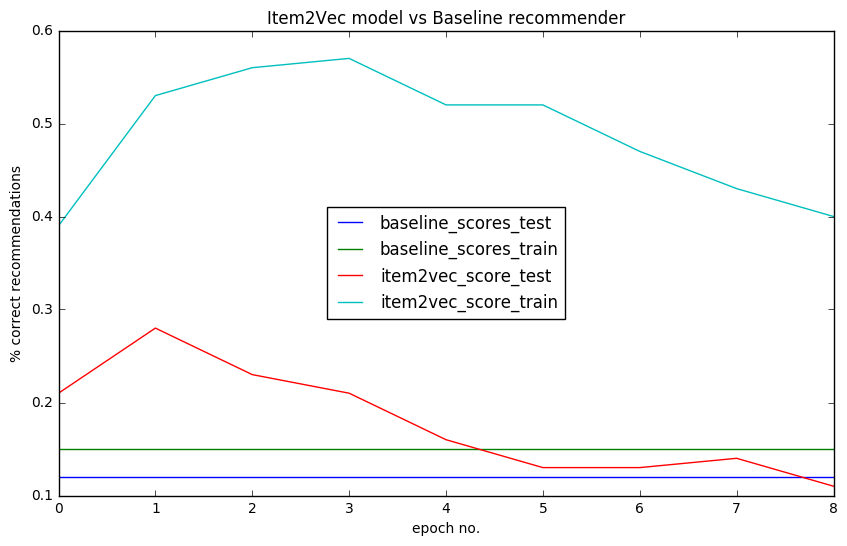

In [43]:
df=pd.DataFrame.from_dict({'item2vec_score_train': scores,
                           'item2vec_score_test' : scores_test,
                           'baseline_scores_train':scores_baseline,
                           'baseline_scores_test':scores_baseline_test})
df.plot(figsize=(10,6))
plt.title('Item2Vec model vs Baseline recommender')
plt.xlabel('epoch no.')
plt.ylabel('% correct recommendations')

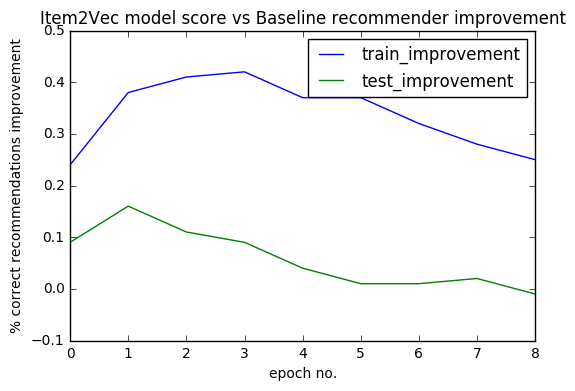

In [42]:
df['train_improvement']=df['item2vec_score_train']-df['baseline_scores_train']
df['test_improvement']=df['item2vec_score_test']-df['baseline_scores_test']
df_diffs=df.reindex_axis(['train_improvement','test_improvement'], axis=1)
df_diffs.plot()
plt.title('Item2Vec model score vs Baseline recommender improvement')
plt.xlabel('epoch no.')
plt.ylabel('% correct recommendations improvement')